Pip install the following packages
1. polars
2. wetterdienst
3. shapely
4. utm

In [31]:
import pandas as pd
import datetime as dt
import utm
from scipy.interpolate import LinearNDInterpolator
from shapely.geometry import Point, Polygon
from wetterdienst import Settings, Resolution, Period, Parameter
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution

In [3]:
settings = Settings(
    ts_shape="long",
    ts_humanize=True,
    ts_si_units=True
)

All the observations we would need are as follows
1. wind_speed
2. wind_direction
3. radiation_global
4. air_temperature
5. humidity
6. wind_gust_max
7. extreme_wind
8. wind_direction_gust_max

There are 298 weather stations in germany 

**INTERPOLATION**

The function leverages the four closest stations to your specified latitude and longitude and employs the bilinear interpolation method provided by the scipy package (interp2d) to interpolate the given parameter values. Currently, this interpolation feature is exclusive to DWDObservationRequest and parameters temperature_air_mean_200, wind_speed, precipitation_height. As it is in its early stages, we welcome feedback to enhance and refine its functionality. Interpolation by nearby stations is limited to a distance of 40 km by default (20.0 km for precipitation). You can change this by setting the ts_interpolation_station_distance setting.


In [32]:
langenhorn = (54.679, 8.908)

In [35]:
request = DwdObservationRequest(
    parameter="wind_speed",
    resolution="10_minutes",
    start_date="2022-01-01",
    end_date="2023-04-12"
)


stations = request.filter_by_rank(latlon=langenhorn, rank=5)

nearby_stations = stations.df
nearby_stations.head()

station_id,start_date,end_date,latitude,longitude,height,name,state,distance
str,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,f64,str,str,f64
"""02907""",1999-02-02 00:00:00 UTC,2024-02-19 00:00:00 UTC,54.7903,8.9514,7.0,"""Leck""","""Schleswig-Hols…",12.685763
"""04919""",1993-05-13 00:00:00 UTC,2024-02-18 00:00:00 UTC,54.4965,8.8069,7.0,"""Strucklahnungs…","""Schleswig-Hols…",21.312964
"""01963""",1993-08-13 00:00:00 UTC,2024-02-19 00:00:00 UTC,54.5742,8.5133,4.0,"""Hallig Hooge""","""Schleswig-Hols…",27.952158
"""19243""",2024-01-01 00:00:00 UTC,2024-02-18 00:00:00 UTC,54.6831,8.4721,8.0,"""Föhr""","""Schleswig-Hols…",28.025428
"""01379""",1996-03-01 00:00:00 UTC,2024-02-18 00:00:00 UTC,54.7737,9.3753,41.0,"""Flensburg (Sch…","""Schleswig-Hols…",31.800727


In [36]:
def get_weather_data(param):
    request = DwdObservationRequest(
        parameter=[
             param 
        ],
        resolution="10_minutes",
        start_date="2020-01-01",
        end_date="2023-12-31",
        settings=settings
    )
    stations = request.filter_by_rank(latlon=langenhorn, rank=1)
    df = stations.values.all().df.drop_nulls() 
    return df

**Weather attributes**

In [52]:
df_wind_speed = get_weather_data("wind_speed") # mean of wind speed during the last 10 minutes in m/s
df_wind_speed = df_wind_speed.drop(["dataset", "parameter", "quality"])
df_wind_speed = df_wind_speed.rename({"value": "ws_value"})

In [38]:
df_wind_direction = get_weather_data("wind_direction") # mean of wind direction during the last 10 minutes in degrees
df_wind_direction = df_wind_direction.drop(["dataset", "parameter", "quality"])
df_wind_direction = df_wind_direction.rename({"value": "wd_value"})

In [39]:
df_radiation_global = get_weather_data("radiation_global") # 10min-sum of solar incoming radiation in J/m2
df_radiation_global = df_radiation_global.drop(["dataset", "parameter", "quality"])
df_radiation_global = df_radiation_global.rename({"value": "rg_value"})

In [40]:
df_air_temperature = get_weather_data("air_temperature") # # Historical 10-minute station observations of pressure, air temperature (at 5cm and 2m height), humidity and dew point for Germany
df_air_temperature = df_air_temperature.drop(["dataset", "parameter", "quality"])
df_air_temperature = df_air_temperature.rename({"value": "at_value"})

In [41]:
df_humidity = get_weather_data("humidity") # relative humidity at 2m height in %
df_humidity = df_humidity.drop(["dataset", "parameter", "quality"])
df_humidity = df_humidity.rename({"value": "h_value"})

In [42]:
df_wind_gust_max = get_weather_data("wind_gust_max")# # maximum wind gust of the last 10 minutes, the instrument samples the instantaneous wind velocity every 0.25 seconds, and writes out the max value of a 3 second period, the highest occuring within the 10min interval is given here as the maximum wind gust.
df_wind_gust_max = df_wind_gust_max.drop(["dataset", "parameter", "quality"])
df_wind_gust_max = df_wind_gust_max.rename({"value": "wgm_value"})

In [43]:
df_extreme_wind = get_weather_data("extreme_wind") # Historical 10-minute station observations of max/min - mean wind speed and wind gust for Germany
df_extreme_wind = df_extreme_wind.drop(["dataset", "parameter", "quality"])
df_extreme_wind = df_extreme_wind.rename({"value": "ew_value"})

In [44]:
df_wind_direction_gust_max = get_weather_data("wind_direction_gust_max") # wind direction of highest wind gust 
df_wind_direction_gust_max = df_wind_direction_gust_max.drop(["dataset", "parameter", "quality"])
df_wind_direction_gust_max = df_wind_direction_gust_max.rename({"value": "wdgm_value"})

**Joining all dataframes into one master df**

In [45]:
new_df = df_wind_speed.join(df_wind_direction, on=["station_id","date"], how = "inner")

In [46]:
new_df = new_df.join(df_radiation_global, on=["station_id","date"], how = "inner")

In [47]:
new_df = new_df.join(df_air_temperature, on=["station_id","date"], how = "inner")

In [48]:
new_df = new_df.join(df_humidity, on=["station_id","date"], how = "inner")

In [49]:
new_df = new_df.join(df_wind_gust_max, on=["station_id","date"], how = "inner")

In [50]:
new_df = new_df.join(df_extreme_wind, on=["station_id","date"], how = "inner")

In [51]:
new_df = new_df.join(df_wind_direction_gust_max, on=["station_id","date"], how = "inner")

new_df.head()

station_id,date,ws_value,wd_value,rg_value,at_value,h_value,wgm_value,ew_value,wdgm_value
str,"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64
"""02907""",2020-01-01 00:00:00 UTC,2.7,260.0,0.0,80.5,80.5,3.9,260.0,260.0
"""02907""",2020-01-01 00:00:00 UTC,2.7,260.0,0.0,80.5,80.5,3.9,3.9,260.0
"""02907""",2020-01-01 00:00:00 UTC,2.7,260.0,0.0,80.5,80.5,3.9,1.8,260.0
"""02907""",2020-01-01 00:00:00 UTC,2.7,260.0,0.0,80.5,80.5,3.9,3.0,260.0
"""02907""",2020-01-01 00:10:00 UTC,3.1,260.0,0.0,78.5,78.5,5.5,250.0,250.0


**Converting UTC to UTC+1 or UTC+2**


Standard time:	UTC +1	Central European Time (CET)
Daylight saving time:	UTC +2	Central European Summertime (CEST)
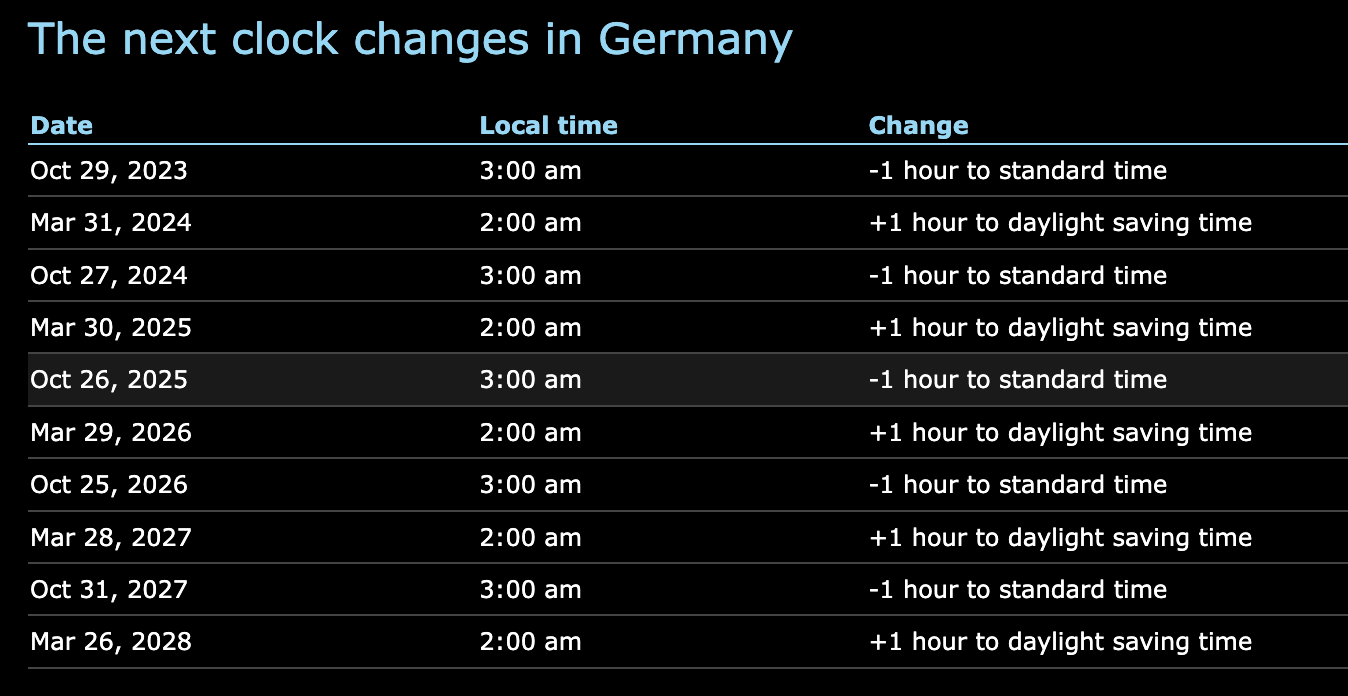


In [ ]:
def add_timedelta_based_on_month(dt):
    if dt.month in [4, 5, 6, 7, 8, 9, 10]:  # Summer months: April, May, June, July, August, September, October
        return dt + pd.Timedelta(hours=2)
    else:  # Winter months: November, December, January, February, March 
        return dt + pd.Timedelta(hours=1)

In [ ]:
new_df['date'] = new_df['date'].apply(add_timedelta_based_on_month)
new_df.head()